In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
!nvidia-smi

Thu May  2 07:15:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 1


**Importing the necessary libraries**

In [ ]:
pip install astroNN

In [70]:
import pandas as pd
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
from tensorflow.keras import utils
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.utils import to_categorical #ask Converts a class vector (integers) to binary class matrix.
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import ParameterSampler # it will allow to create random variations in the model
#building neural network
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D

from sklearn.utils.multiclass import unique_labels
import matplotlib.image as mpimg
import itertools
from sklearn.metrics import confusion_matrix
from keras import Sequential
from tensorflow.keras.applications import VGG19 #For Transfer Learning
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout


# Data Loading
**Loading the images and labels from dataset file h5 that contains multidimensional arrays**

In [6]:
if not os.path.isfile('/content/drive/MyDrive/Galactic_Scholors/Galaxy10_DECals.h5'):
    url = 'https://astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5'
    print("ERROR: download dataset from: ", url)
if os.path.isdir('Galaxy10'):
    import shutil
    shutil.rmtree('Galaxy10')

In [7]:
with h5py.File('/content/drive/MyDrive/Galactic_Scholors/Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
    ra = np.array(F['ra'])
    dec = np.array(F['dec'])
    z = np.array(F['redshift'])

print('Data loaded successfully')

#Galaxy10 dataset (17736 images)
#├── Class 0 (1081 images): Disturbed_Galaxies
#├── Class 1 (1853 images): Merging_Galaxies
#├── Class 2 (2645 images): Round_Smooth_Galaxies
#├── Class 3 (2027 images): In-between_Round_Smooth_Galaxies
#├── Class 4 ( 334 images): Cigar_Shaped_Smooth_Galaxies
#├── Class 5 (2043 images): Barred_Spiral_Galaxies
#├── Class 6 (1829 images): Unbarred_Tight_Spiral_Galaxies
#├── Class 7 (2628 images): Unbarred_Loose_Spiral_Galaxies
#├── Class 8 (1423 images): Edge-on_Galaxies_without_Bulge
#└── Class 9 (1873 images): Edge-on_Galaxies_with_Bulge

class_names = ['Disturbed', 'Merging', 'Round_Smooth',
               'In-between_Round_Smooth', 'Cigar_Shaped_Smooth', 'Barred_Spiral',
               'Unbarred_Tight_Spiral', 'Unbarred_Loose_Spiral', 'Edge-on_without_Bulge',
               'Edge-on_with_Bulge']

Data loaded successfully


In [9]:
print('Images shape:',images.shape)

Images shape: (17736, 256, 256, 3)


In [10]:
print('labels:', labels)

labels: [0 0 0 ... 9 9 9]


# Data preparation

**Converting labels into 10 categorical classes**

In [13]:
# Convert labels into 10 categorical classes
labels_cat = utils.to_categorical(labels, 10)
print('Categorical label:', labels_cat[0])
print('Shape of data structure labels {} and images {}'.format(labels_cat.shape, images.shape))

Categorical label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Shape of data structure labels (17736, 10) and images (17736, 256, 256, 3)


In [14]:
print(labels_cat)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


**Filtering the dataset to include galaxies with redshift under 0.08 and create a new balanced dataset using undersampling**

In [15]:
# Step 1: Filter the dataset to include galaxies with redshift under 0.08
filtered_indices = np.where(z < 0.08)[0]
filtered_images = images[filtered_indices]
filtered_labels = labels[filtered_indices]

# Reshape the images array to 2D
num_samples, height, width, channels = filtered_images.shape
reshaped_images = filtered_images.reshape(num_samples, height * width * channels)

# Step 2: Apply undersampling technique
undersampler = RandomUnderSampler()
undersampled_images, undersampled_labels = undersampler.fit_resample(reshaped_images, filtered_labels)

# Check the class distribution after undersampling
undersampled_labels_cat = to_categorical(undersampled_labels, num_classes=10)
class_distribution_after_undersampling = np.sum(undersampled_labels_cat, axis=0)
print("Class distribution after undersampling:", class_distribution_after_undersampling)

Class distribution after undersampling: [234. 234. 234. 234. 234. 234. 234. 234. 234. 234.]


In [17]:
# Reshape undersampled_images to (2340, 256, 256, 3)
x_res = undersampled_images.reshape(-1, 256, 256, 3)
print('Images shape:',x_res.shape)

Images shape: (2340, 256, 256, 3)


In [19]:
y_res = undersampled_labels
print('Labels shape:',y_res.shape)

Labels shape: (2340,)


In [20]:
print('Labels:',y_res)

Labels: [0 0 0 ... 9 9 9]


In [21]:
# One hot encoding the labels
labels_cat_1 = utils.to_categorical(y_res, 10)
print('Categorical label:', labels_cat_1[0])
print('Shape of data structure labels {} and images {}'.format(labels_cat_1.shape, x_res.shape))

Categorical label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Shape of data structure labels (2340, 10) and images (2340, 256, 256, 3)


**Splitting the resampled dataset into training and testing**

In [22]:
# Use train_test_split to create 4 variables: X_train, X_test, y_train, y_test
# train and test set
X_train, X_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.2, random_state=101, stratify=y_res)

In [23]:
X_train.shape # 80% of data in training set

(1872, 256, 256, 3)

In [24]:
X_test.shape

(468, 256, 256, 3)

In [25]:
y_train[:5]

array([2, 1, 5, 3, 3], dtype=uint8)

In [26]:
class_names[9]

'Edge-on_with_Bulge'

In [27]:
def plot_sample(X, y, index):
    plt.figure(figsize = (15,2))
    plt.imshow(X[index])
    plt.xlabel(class_names[y[index]])

In [45]:
print("Class names:",class_names)

Class names: ['Disturbed', 'Merging', 'Round_Smooth', 'In-between_Round_Smooth', 'Cigar_Shaped_Smooth', 'Barred_Spiral', 'Unbarred_Tight_Spiral', 'Unbarred_Loose_Spiral', 'Edge-on_without_Bulge', 'Edge-on_with_Bulge']


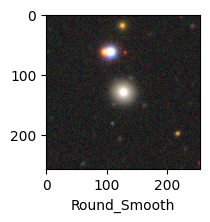

In [39]:
plot_sample(X_train, y_train, 0)

**Resizing the images to 64 x 64**

In [46]:
sample_pic = X_train[4]

In [47]:
sample_pic.shape

(256, 256, 3)

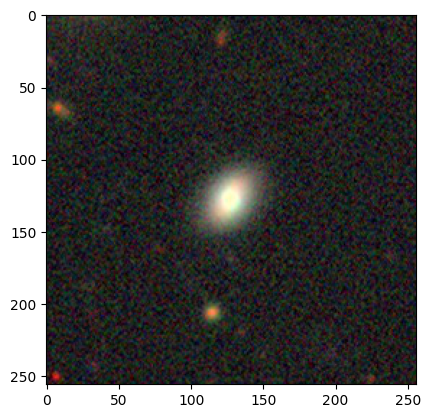

In [53]:
plt.imshow(sample_pic)

In [49]:
newimage = cv2.resize(sample_pic,(64, 64))

In [50]:
newimage.shape

(64, 64, 3)

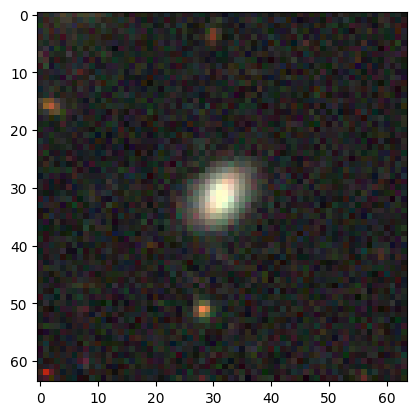

In [52]:
plt.imshow(newimage)

In [54]:
X_train.shape[0]

1872

In [55]:
total_rows = X_train.shape[0]

In [56]:
arr = []
for i in range(total_rows):
  image = X_train[i]
  image = cv2.resize(image,(64, 64))
  arr.append(image)

In [ ]:
arr[:2]

In [58]:
type(arr[0])

numpy.ndarray

In [59]:
# Convert arr list to an array and save this pre-processed list as the new X_train set.

X_train = np.asarray(arr)

In [60]:
X_train.shape

(1872, 64, 64, 3)

In [61]:
# Applying the same procedure to test data .
arr = []
for i in range(X_test.shape[0]):
    image = X_test[i]
    image = cv2.resize(image, (64, 64))
    arr.append(image)

In [62]:
X_test = np.asarray(arr)

**Normalizing data**

In [63]:
X_train = X_train/255.0
X_test = X_test/255.0

In [ ]:
X_train[:2]

In [64]:
X_train.shape, X_test.shape

((1872, 64, 64, 3), (468, 64, 64, 3))

**Splitting the training data into training and validation sets**

In [66]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=.3)

In [67]:
print((X_train.shape,y_train.shape))
print((X_val.shape,y_val.shape))
print((X_test.shape,y_test.shape))

((1310, 64, 64, 3), (1310,))
((562, 64, 64, 3), (562,))
((468, 64, 64, 3), (468,))


**Converting the target variable into categorical data**

In [68]:
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

In [69]:
print((X_train.shape,y_train.shape))
print((X_val.shape,y_val.shape))
print((X_test.shape,y_test.shape))

((1310, 64, 64, 3), (1310, 10))
((562, 64, 64, 3), (562, 10))
((468, 64, 64, 3), (468, 10))


# Data augmentation

In [71]:
# Define data augmentation parameters
train_generator = ImageDataGenerator(
    rotation_range=20,      # Rotate the image by up to 20 degrees
    width_shift_range=0.2,  # Shift the image horizontally by up to 20% of the width
    height_shift_range=0.2, # Shift the image vertically by up to 20% of the height
    shear_range=0.2,        # Apply shear transformation with intensity up to 20%
    zoom_range=0.2,         # Zoom into the image by up to 20%
    horizontal_flip=True,   # Flip the image horizontally
    vertical_flip=True,     # Flip the image vertically
    fill_mode='nearest'     # Fill in missing pixels using the nearest pixel value
)
val_generator = ImageDataGenerator(
    rotation_range=20,      # Rotate the image by up to 20 degrees
    width_shift_range=0.2,  # Shift the image horizontally by up to 20% of the width
    height_shift_range=0.2, # Shift the image vertically by up to 20% of the height
    shear_range=0.2,        # Apply shear transformation with intensity up to 20%
    zoom_range=0.2,         # Zoom into the image by up to 20%
    horizontal_flip=True,   # Flip the image horizontally
    vertical_flip=True,     # Flip the image vertically
    fill_mode='nearest'     # Fill in missing pixels using the nearest pixel value
)
test_generator = ImageDataGenerator(
    rotation_range=20,      # Rotate the image by up to 20 degrees
    width_shift_range=0.2,  # Shift the image horizontally by up to 20% of the width
    height_shift_range=0.2, # Shift the image vertically by up to 20% of the height
    shear_range=0.2,        # Apply shear transformation with intensity up to 20%
    zoom_range=0.2,         # Zoom into the image by up to 20%
    horizontal_flip=True,   # Flip the image horizontally
    vertical_flip=True,     # Flip the image vertically
    fill_mode='nearest'     # Fill in missing pixels using the nearest pixel value
)

#Fitting the augmentation defined above to the data
train_generator.fit(X_train)
val_generator.fit(X_val)
test_generator.fit(X_test)

# Model building and training

In [72]:
lrr= ReduceLROnPlateau(monitor='val_accuracy', factor=.01, patience=3, min_lr=1e-5)

In [73]:
base_model = VGG19(include_top = False, weights = 'imagenet', input_shape = (64,64,3), classes = y_train.shape[1])

80134624/80134624 [==============================] - 4s 0us/step


In [74]:
model= Sequential()
model.add(base_model)
model.add(Flatten())

In [75]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
Total params: 20024384 (76.39 MB)
Trainable params: 20024384 (76.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [76]:
model.add(Dense(1024,activation=('relu'),input_dim=512))
model.add(Dense(512,activation=('relu')))
model.add(Dense(256,activation=('relu')))
model.add(Dropout(.3))
model.add(Dense(128,activation=('relu')))
#model.add(Dropout(.2))
model.add(Dense(10,activation=('softmax')))

In [77]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

In [87]:
batch_size= 20
epochs=50
learn_rate=.001
sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [88]:
model.fit_generator(
    train_generator.flow(X_train, y_train, batch_size= batch_size),
    epochs = epochs,
    steps_per_epoch = len(X_train)//batch_size,
    validation_data = val_generator.flow(X_val, y_val, batch_size = batch_size),
    validation_steps =10, callbacks=[lrr],
    verbose = 1
)

Epoch 1/50


<ipython-input-88-cbf79adf6cc8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


65/65 [==============================] - 10s 63ms/step - loss: 1.1336 - accuracy: 0.6085 - val_loss: 1.1641 - val_accuracy: 0.5750 - lr: 0.0010
Epoch 2/50
65/65 [==============================] - 4s 60ms/step - loss: 1.1485 - accuracy: 0.5961 - val_loss: 1.1210 - val_accuracy: 0.5750 - lr: 0.0010
Epoch 3/50
65/65 [==============================] - 4s 68ms/step - loss: 1.0753 - accuracy: 0.6202 - val_loss: 1.2509 - val_accuracy: 0.5450 - lr: 0.0010
Epoch 4/50
65/65 [==============================] - 4s 60ms/step - loss: 1.0759 - accuracy: 0.6186 - val_loss: 1.1821 - val_accuracy: 0.5950 - lr: 0.0010
Epoch 5/50
65/65 [==============================] - 4s 64ms/step - loss: 1.0196 - accuracy: 0.6434 - val_loss: 1.3208 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 6/50
65/65 [==============================] - 5s 72ms/step - loss: 1.0560 - accuracy: 0.6473 - val_loss: 1.1167 - val_accuracy: 0.6150 - lr: 0.0010
Epoch 7/50
65/65 [==============================] - 4s 61ms/step - loss: 0.9350 - accu

In [89]:
model.evaluate(X_test,y_test)

15/15 [==============================] - 0s 22ms/step - loss: 0.9344 - accuracy: 0.7158


[0.9344424605369568, 0.7158119678497314]

In [90]:
y_pred=model.predict(X_test)
classes_x=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_test,axis=1)

15/15 [==============================] - 0s 21ms/step


In [93]:
y_pred.shape

(468, 10)

In [95]:
classes_x.shape

(468,)

In [98]:
y_true.shape

(468,)

In [104]:
for i in range(10):
    print("Actual:", class_names[y_true[i]])
    print("Prediction:", class_names[classes_x[i]])
    print("-----")
    print()

Actual: Unbarred_Loose_Spiral
Prediction: Unbarred_Loose_Spiral
-----

Actual: In-between_Round_Smooth
Prediction: In-between_Round_Smooth
-----

Actual: Unbarred_Tight_Spiral
Prediction: Unbarred_Tight_Spiral
-----

Actual: Merging
Prediction: Merging
-----

Actual: Unbarred_Loose_Spiral
Prediction: Unbarred_Loose_Spiral
-----

Actual: Unbarred_Loose_Spiral
Prediction: Merging
-----

Actual: Merging
Prediction: Merging
-----

Actual: In-between_Round_Smooth
Prediction: In-between_Round_Smooth
-----

Actual: Merging
Prediction: Merging
-----

Actual: Round_Smooth
Prediction: Round_Smooth
-----



In [105]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    #Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    #Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
    np.set_printoptions(precision=2)

Confusion matrix, without normalization


<Axes: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

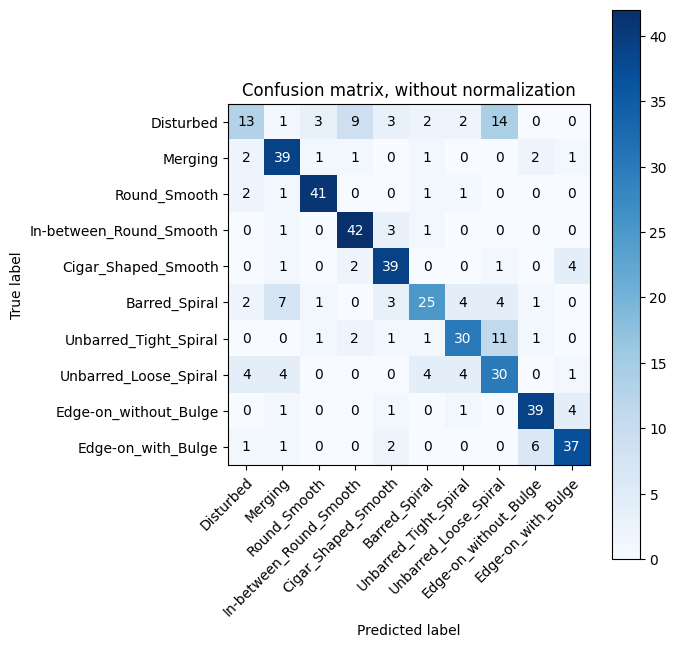

In [107]:
#Plotting the confusion matrix
confusion_mtx =confusion_matrix(y_true, classes_x)

#Defining the class labels
class_names = ['Disturbed', 'Merging', 'Round_Smooth',
               'In-between_Round_Smooth', 'Cigar_Shaped_Smooth', 'Barred_Spiral',
               'Unbarred_Tight_Spiral', 'Unbarred_Loose_Spiral', 'Edge-on_without_Bulge',
               'Edge-on_with_Bulge']

# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true, classes_x, classes = class_names, title='Confusion matrix, without normalization')

In [109]:
model.save('trained_galaxy10_model_1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
